In [33]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models

# for creating test labels
import csv
import os
import shutil

In [38]:
# Visualization libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [66]:
# for more specific training
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


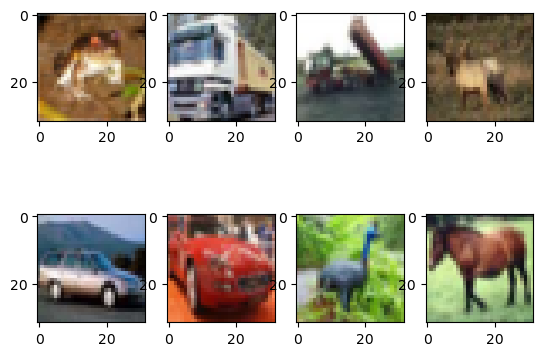

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [10]:
# Convolution model
model1 = models.Sequential()
input_shape = (32, 32, 3)  # Input shape of the image
num_classes = 10  # Number of output classes (0-9 inclusive)

### ATTEMPT 1 : ACC 10%

# # layers
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# # Flatten the output for Dense layers
# model.add(layers.Flatten())

# # dense layers
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer with softmax activation for classification

### ATTEMPT 2 

# Convolutional layers
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for Dense layers
model1.add(layers.Flatten())

# Dense layers
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(num_classes, activation='softmax'))  


# ### ATTEMPT 3 ACC 38.6%

# model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))

# model1.add(layers.Conv2D(32, (3, 3), padding = 'same'))
# model1.add(layers.Activation('relu'))

# model1.add(layers.MaxPooling2D(pool_size= (2,2)))
# model1.add(layers.Dropout(0.25))

# model1.add(layers.Conv2D(64, (3, 3), padding = 'same'))
# model1.add(layers.Activation('relu'))

# model1.add(layers.Conv2D(64, (3, 3)))
# model1.add(layers.Activation('relu'))

# model1.add(layers.MaxPooling2D(pool_size= (2, 2)))
# model1.add(layers.Dropout(0.25))

# #Dense layers
# model1.add(layers.Flatten())
# model1.add(layers.Dense(512))
# model1.add(layers.Activation('relu'))
# model1.add(layers.Dropout(0.5))
# model1.add(layers.Dense(num_classes))
# model1.add(layers.Activation('softmax'))

# Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # so no need for one hot encoding
              metrics=['accuracy'])

# Print model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [11]:
x_train = imgs[10000:, :, :, :]  # all images after first 10000
x_test = imgs[:10000, :, : , :]  # first 10000 clean images

y_train = noisy_labels[10000:] # train on all noisy labels after first 10000
y_test = clean_labels #clean labels for first 10000 images

In [12]:
# Train the model
history = model1.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model1.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10


2024-03-19 16:33:26.795965: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1250/1250 [==============================] - 48s 38ms/step - loss: 2.3163 - accuracy: 0.1241 - val_loss: 2.1285 - val_accuracy: 0.2429
Epoch 2/10
1250/1250 [==============================] - 46s 37ms/step - loss: 2.2720 - accuracy: 0.1516 - val_loss: 2.1376 - val_accuracy: 0.3301
Epoch 3/10
1250/1250 [==============================] - 47s 37ms/step - loss: 2.2581 - accuracy: 0.1726 - val_loss: 2.0758 - val_accuracy: 0.3429
Epoch 4/10
1250/1250 [==============================] - 47s 38ms/step - loss: 2.2467 - accuracy: 0.1852 - val_loss: 1.9947 - val_accuracy: 0.4042
Epoch 5/10
1250/1250 [==============================] - 49s 39ms/step - loss: 2.2411 - accuracy: 0.1904 - val_loss: 1.9990 - val_accuracy: 0.3876
Epoch 6/10
1250/1250 [==============================] - 49s 40ms/step - loss: 2.2347 - accuracy: 0.1983 - val_loss: 1.9870 - val_accuracy: 0.3822
Epoch 7/10
1250/1250 [==============================] - 51s 41ms/step - loss: 2.2272 - accuracy: 0.2049 - val_loss: 1.9698 - val_accura

In [45]:
# Treats noisy labels as clean labels and does not differentiate between the two
# Input : (32, 32, 3) (32x32 pixels, 3 RGB channel) image
# Output : Numerical classification label [0-9] 
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_data = np.zeros((1, 32, 32, 3))
    img_data[0] = image
    probs = model1.predict(img_data[:1, :, :, :],verbose = 0) # verbose to stop printing the time/step line
    return np.argmax(probs)

In [26]:
# save cnn model
model1.save('model1_V1.h5')  # Save in HDF5 format

[[0.08505396 0.16205873 0.07207845 0.07869598 0.05690672 0.08659212
  0.06432969 0.05944193 0.11188725 0.2229551 ]]


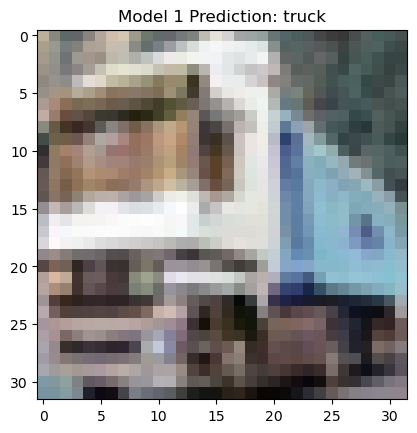

In [43]:
# Example 
folder_path =  "/Users/swzhao/Desktop/Columbia/Applied Data Science/Project 2 - Weakly Supervised learning/"
img = cv2.imread(folder_path+'data/images/00002.png')

plt.imshow(img)
plt.title("Model 1 Prediction: " + str(classes[int(model_I(img))]))
plt.show()

### Some commentary on Model I

This is a convolutional neural network which is a more sophisticated framework than the baseline logistic regression model given to us.

The model achieved a final test accuracy of 0.4414 after running for 10 epochs on the noisy labeled images. This accuracy is much higher than random guess (which would have an expected accuracy of 0.10 assuming equally uniform distribution of all image categories) and decently higher than the baseline regression model's accurary of 0.24. 

This model can be further improved through several following means:
 - Data augmentation of the images we are training and testing on (this gives the model more information to work with)
 - More sophisticated weights and layers
 - More training data and more training time (we see that val_accuracy fluctuates around ~0.4 while training_accuracy is incrementally increasing. We would like to avoid overfitting while converging around the optimal weights. Perhaps a narrower and finer step size than the default Optimizer Adam's 0.001 would be better).
 
However, for demonstration purposes, this model is sufficient in showcasing superior abilities compared to the logistic model
 
Of course, the data and corresponding label quality is also very important for the model. Having clean labels and not erroneous labels would be very beneficial. This is what we are going to explore in part II.


### Some Visualizations for Model I

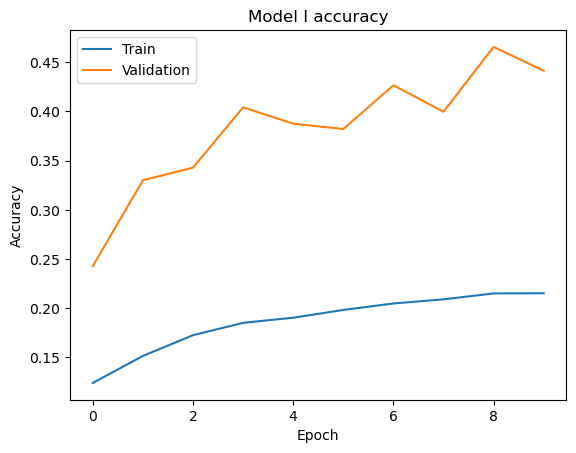

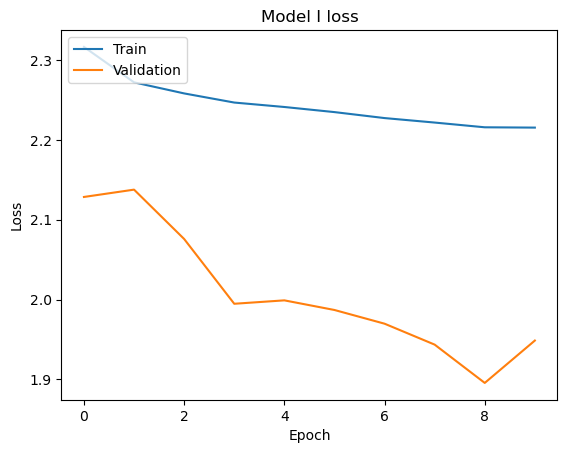

In [32]:
## Accuracy and Loss

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model I accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model I loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
# Get set of predictions
y_true = clean_labels
y_pred = [model_I(img) for img in imgs[:10000]]

In [48]:
# Predicted probabilities
y_pred_prob = []

for img in imgs[:10000]:
    img_data = np.zeros((1, 32, 32, 3))
    img_data[0] = img
    probs = model1.predict(img_data[:1, :, :, :],verbose = 0) # verbose to stop printing the time/step line
    
    y_pred_prob.append(probs)

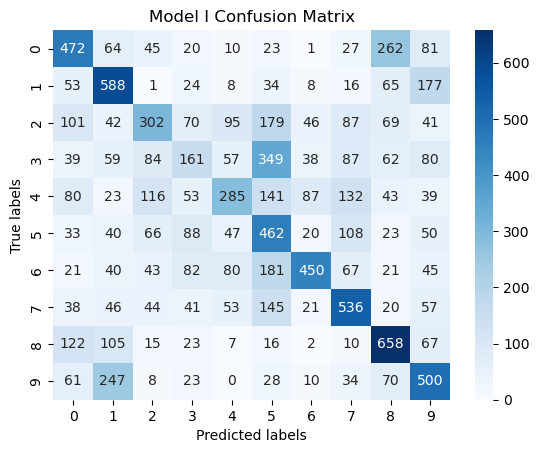

In [52]:
## Confusion Matrix

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Model I Confusion Matrix')
plt.show()

### 2.3. Model II


As noted before in the commentary on Model I, one way to improve the model's accuracy would be to train on better data. In this case, the better data refers to data with "clean" labels. That is, instead of treating noisy labels as clean labels, we apply some cleaning to our dataset to adjust the unclean labels.

In this case, we try to replicate the method from "Multi-Label Fashion Image Classification with Minimal Human Supervision". The link to the paper:

https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w32/Inoue_Multi-Label_Fashion_Image_ICCV_2017_paper.pdf

The idea behind the method is as such: as we train, we "manually" correct the labels for a small subset of the data and use these labels to train. In this case, the "manual" correction is not human-manual, but rather the result of our "label cleaning network".

We create a separate neural network that learns the mappings between the clean and unclean labels. As input, this takes both the unclean label and the image and outputs the "clean" label. This model is then used to adjust our training data so we have a set of privileged data that is the target for our image classifier CNN.

### Model II Part 1: Unclean to Clean Label NN

Input: (32,32, 3) Image, (1,) numerical unclean label [0-9]

Output: (1,) hopefully clean label [0-9]

In [94]:
# input layers for image and unclean label
image_input = tf.keras.layers.Input(shape=(32, 32, 3), name='image_input')
unclean_label_input = tf.keras.layers.Input(shape=(1,), name='unclean_label_input')

# flattened_image = tf.keras.layers.Flatten()(image_input)

# # put two inputs together
# concatenated_inputs = tf.keras.layers.Concatenate()([flattened_image, unclean_label_input])

# # dense for feature extraction
# dense1 = tf.keras.layers.Dense(128, activation='relu')(concatenated_inputs)
# dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)

# # Output layer
# output = tf.keras.layers.Dense(10, activation='softmax', name='output')(dense2)

# # Define the model with multiple inputs
# model_label = tf.keras.models.Model(inputs=[image_input, unclean_label_input], outputs=output)

# # Compile the model
# model_label.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model_label.summary()

### ATTEMPT 2

# conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
# pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
# conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool1)
# pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
# conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(pool2)
# pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

# # Flatten the pooled features
# flattened_pool = tf.keras.layers.Flatten()(pool3)

# # Concatenate flattened image and unclean label inputs
# concatenated_inputs = tf.keras.layers.Concatenate()([flattened_pool, unclean_label_input])

# # Dense layers for feature extraction
# dense1 = tf.keras.layers.Dense(256, activation='relu')(concatenated_inputs)
# dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
# dense3 = tf.keras.layers.Dense(64, activation='relu')(dense2)

# # Output layer
# output = tf.keras.layers.Dense(10, activation='softmax', name='output')(dense3)

# # Define the model with multiple inputs
# model_label = tf.keras.models.Model(inputs=[image_input, unclean_label_input], outputs=output)

# # Compile the model
# model_label.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model_label.summary()

### ATTEMPT 3

# conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
# conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
# pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

# conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
# conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
# pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

# # Flatten the pooled features
# flattened_pool = tf.keras.layers.Flatten()(pool2)

# # Concatenate flattened image and unclean label inputs
# concatenated_inputs = tf.keras.layers.Concatenate()([flattened_pool, unclean_label_input])

# # Add dropout for regularization
# dropout1 = tf.keras.layers.Dropout(0.25)(concatenated_inputs)

# # Dense layers for feature extraction
# dense1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
# dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)

# # Add dropout for regularization
# dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

# # Output layer
# output = tf.keras.layers.Dense(10, activation='softmax', name='output')(dropout2)

# # Define the model with multiple inputs
# model_label = tf.keras.models.Model(inputs=[image_input, unclean_label_input], outputs=output)

# # Compile the model
# model_label.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Print model summary
# model_label.summary()

## ATTEMPT 4

# Apply convolutional and pooling layers for image input
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

# Flatten the pooled features
flattened_pool = tf.keras.layers.Flatten()(pool2)

# Concatenate flattened image and unclean label inputs
concatenated_inputs = tf.keras.layers.Concatenate()([flattened_pool, unclean_label_input])

# Add dropout for regularization
dropout1 = tf.keras.layers.Dropout(0.25)(concatenated_inputs)

# Dense layers for feature extraction
dense1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)

# Add dropout for regularization
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

# Output layer
output = tf.keras.layers.Dense(10, activation='softmax', name='output')(dropout2)

# Define the model with multiple inputs
model_label = tf.keras.models.Model(inputs=[image_input, unclean_label_input], outputs=output)

# Compile the model
model_label.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_label.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 32, 32, 32)   896         ['image_input[0][0]']            
                                                                                                  
 conv2d_24 (Conv2D)             (None, 32, 32, 64)   18496       ['conv2d_23[0][0]']              
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 16, 16, 64)  0           ['conv2d_24[0][0]']              
 )                                                                                          

In [95]:
# for training
x_train_image = imgs[:9000, :, :, :]  # first 9000 images
x_train_label = noisy_labels[:9000] # first 9000 unclean labels
y_train_label_clean = clean_labels[:9000] # first 9000 clean labels (desired output)

#for validation
x_test_image = imgs[9001:10000, :, :, :]  # 9000-10000 images
x_test_label = noisy_labels[9001:10000] # 9000-10000 unclean labels
y_test_label_clean = clean_labels[9001:10000] # 9000-10000 clean labels (desired output)

In [96]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

# Train the model
history_m2labels = model_label.fit([x_train_image,x_train_label], y_train_label_clean, epochs=50, 
                          validation_data=([x_test_image, x_test_label], y_test_label_clean), 
                                   callbacks=[early_stopping, learning_rate_scheduler])

# Evaluate the model
test_loss, test_acc = model_label.evaluate([x_test_image, x_test_label], y_test_label_clean)
print('Test accuracy:', test_acc)

Epoch 1/50
282/282 [==============================] - 17s 61ms/step - loss: 2.7866 - accuracy: 0.1752 - val_loss: 2.1086 - val_accuracy: 0.2012 - lr: 0.0010
Epoch 2/50
282/282 [==============================] - 17s 61ms/step - loss: 2.0625 - accuracy: 0.2402 - val_loss: 1.8385 - val_accuracy: 0.3393 - lr: 0.0010
Epoch 3/50
282/282 [==============================] - 17s 61ms/step - loss: 1.8326 - accuracy: 0.3368 - val_loss: 1.5508 - val_accuracy: 0.4374 - lr: 0.0010
Epoch 4/50
282/282 [==============================] - 17s 62ms/step - loss: 1.6410 - accuracy: 0.4060 - val_loss: 1.4840 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 5/50
282/282 [==============================] - 17s 62ms/step - loss: 1.4969 - accuracy: 0.4711 - val_loss: 1.3034 - val_accuracy: 0.5165 - lr: 0.0010
Epoch 6/50
282/282 [==============================] - 18s 63ms/step - loss: 1.3534 - accuracy: 0.5182 - val_loss: 1.3454 - val_accuracy: 0.5105 - lr: 0.0010
Epoch 7/50
282/282 [==============================] - 18s 

In [125]:
# Treats noisy labels as clean labels and does not differentiate between the two
# Input : (32, 32, 3) (32x32 pixels, 3 RGB channel) image
# Output : Numerical classification label [0-9] 
def model_label_classifier(image, unclean_label):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_data = np.zeros((1, 32, 32, 3))
    img_data[0] = image
    label_data = np.zeros((1))
    label_data[0] = unclean_label
    probs = model_label.predict([img_data[:1, :, :, :], label_data[:1]],verbose = 0) # verbose to stop printing the time/step line
    return np.argmax(probs)

In [126]:
model_label.save('model_label_V1.h5')

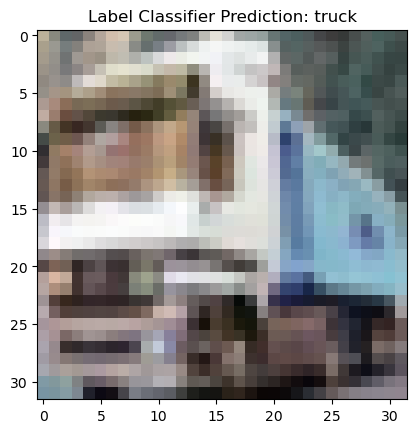

In [127]:
# Example 
folder_path =  "/Users/swzhao/Desktop/Columbia/Applied Data Science/Project 2 - Weakly Supervised learning/"
img = cv2.imread(folder_path+'data/images/00002.png')
plt.imshow(img)

img_data = np.zeros((1, 32, 32, 3))
img_data[0] = img
plt.title("Label Classifier Prediction: " + str(classes[int(model_label_classifier(img, noisy_labels[1]))]))
plt.show()

As we can see, the test accuracy for this neural network is not the most high. However, we can still use it to clean our dataset since it's better than the noisy data.

Some exploratory analysis is demonstrated below. The predicted labels are more likely to be accurate than the noisy ones. 

In [129]:
y_label_true = clean_labels[9001:10000]
y_label_pred = []

for img, noisy in zip(imgs[9001:10000], noisy_labels[9001:10000]):
    y_label_pred.append(int(model_label_classifier(img, noisy_labels[1])))
        

In [131]:
total = len(noisy_labels[9001:10000])
total_wrong = 0
wrong_when_clean_label = 0
num_clean_in_noisy = 0

for pred, truth, noise in zip(y_label_pred, y_label_true, noisy_labels[9001:10000]):
    if truth == noise:
        num_clean_in_noisy += 1
        
    if pred != truth:
        total_wrong +=1 
        
        if truth == noise:
            wrong_when_clean_label += 1

print("Total accuracy: ", (total-total_wrong)/total)
print("Accuracy with clean label: ", (num_clean_in_noisy-wrong_when_clean_label)/num_clean_in_noisy)

Total accuracy:  0.6146146146146146
Accuracy with clean label:  0.6256281407035176


In [132]:
num_differences_clean_noisy = sum(el1 != el2 for el1, el2 in zip(clean_labels[9001:10000], noisy_labels[9001:10000]))

print("Noisy accuracy: ", (total-num_differences_clean_noisy)/total)

Noisy accuracy:  0.3983983983983984


### Model II Part 2: Image Classifier

In [135]:
# clone model1 to demonstrate that all improvements come from label cleaning rather than any new model adjustments
model2 = tf.keras.models.clone_model(model1)

In [136]:
noisy_to_clean_labels = [int(model_label_classifier(img, noise)) for img, noise in zip(imgs, noisy_labels)]

In [145]:
noisy_to_clean_labels = np.array(noisy_to_clean_labels)

In [146]:
x_train = imgs[10000:, :, :, :]  # all images after first 10000
x_test = imgs[:10000, :, : , :]  # first 10000 clean images

y_train = noisy_to_clean_labels[10000:] # train on all "noisy to clean" labels after first 10000
y_test = clean_labels #clean labels for first 10000 images

In [147]:
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [148]:
# Train the model
history_m2 = model2.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
1250/1250 [==============================] - 47s 37ms/step - loss: 1.5003 - accuracy: 0.4767 - val_loss: 1.2876 - val_accuracy: 0.5434
Epoch 2/10
1250/1250 [==============================] - 48s 38ms/step - loss: 1.0862 - accuracy: 0.6108 - val_loss: 1.2056 - val_accuracy: 0.5897
Epoch 3/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.9868 - accuracy: 0.6464 - val_loss: 1.1732 - val_accuracy: 0.6019
Epoch 4/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.9393 - accuracy: 0.6627 - val_loss: 1.1198 - val_accuracy: 0.6119
Epoch 5/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.8857 - accuracy: 0.6809 - val_loss: 1.2112 - val_accuracy: 0.5925
Epoch 6/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.8571 - accuracy: 0.6862 - val_loss: 1.2198 - val_accuracy: 0.5971
Epoch 7/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.8345 - accuracy: 0.7002 - val_loss: 1.1921 -

In [152]:
model2.save("modelII_V1.h5")
np.save('noisytocleanlabels.npy', noisy_to_clean_labels)

In [153]:
# Treats noisy labels as clean labels and does not differentiate between the two
# Input : (32, 32, 3) (32x32 pixels, 3 RGB channel) image
# Output : Numerical classification label [0-9] 
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img_data = np.zeros((1, 32, 32, 3))
    img_data[0] = image
    probs = model2.predict(img_data[:1, :, :, :],verbose = 0) # verbose to stop printing the time/step line
    return np.argmax(probs)

### Some Visualizations for Model II

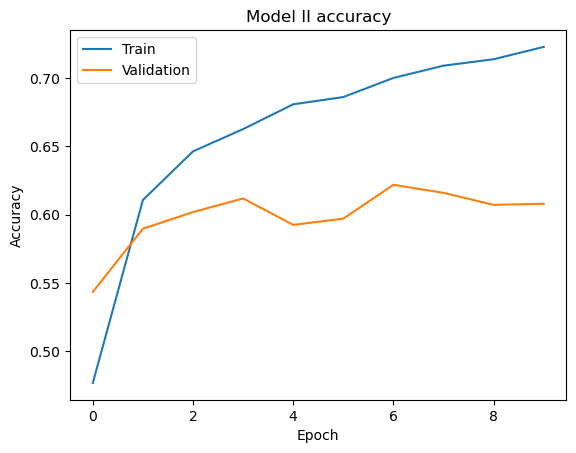

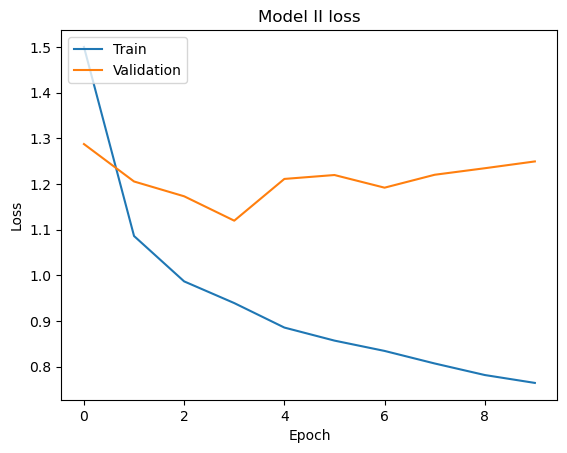

In [154]:
## Accuracy and Loss

# Plot training & validation accuracy values
plt.plot(history_m2.history['accuracy'])
plt.plot(history_m2.history['val_accuracy'])
plt.title('Model II accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_m2.history['loss'])
plt.plot(history_m2.history['val_loss'])
plt.title('Model II loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [155]:
# Get set of predictions
y_true = clean_labels
y_pred2 = [model_II(img) for img in imgs[:10000]]

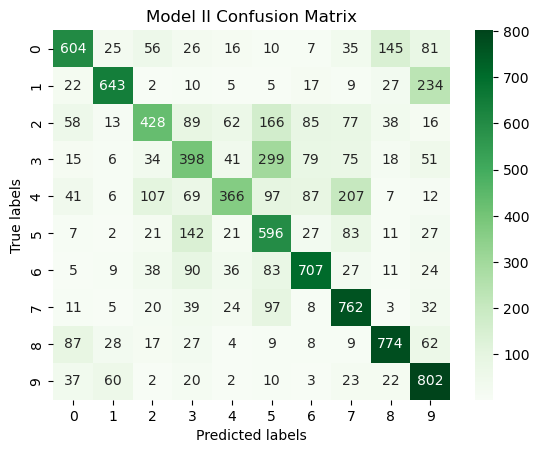

In [157]:
## Confusion Matrix

conf_matrix = confusion_matrix(y_true[:10000], y_pred2)
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Model II Confusion Matrix')
plt.show()

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [158]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [21]:
# create test labels csv
# split portion of clean labels to serve validation purpose
folder_path = "/Users/swzhao/Desktop/Columbia/Applied Data Science/Project 2 - Weakly Supervised learning/"
source_file = folder_path + 'data/clean_labels.csv'
destination_file = folder_path + 'data/test_labels.csv'

# Open the source CSV file for reading
with open(source_file, 'r', newline='') as source_csv_file:
    reader = csv.reader(source_csv_file)
    data = list(reader)

# write first 10000 lines into validation labels
# Open the destination CSV file for writing
with open(destination_file, 'w', newline='') as destination_csv_file:
    writer = csv.writer(destination_csv_file)
    # Write each row from the source CSV file to the destination CSV file
    i = 0
    for row in data:
        writer.writerow(row)
        i+=1
        if i > 10000:
            break

In [29]:
# create test_images folder
data_folder = "../data"
images_folder = os.path.join(data_folder, "images")
test_images_folder = os.path.join(data_folder, "test_images")

# Create the test_images folder if it doesn't exist
if not os.path.exists(test_images_folder):
    os.makedirs(test_images_folder)
    
# Get list of files in the images folder
files = os.listdir(images_folder)
files.sort()
files=files[1:] #remove DS.store

#Copy the first 10000 files
for i, file in enumerate(files):
    if i >= 10000:
        break
    src = os.path.join(images_folder, file)
    dst = os.path.join(test_images_folder, f"test{file}")
    shutil.copy(src, dst)

In [19]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



In [29]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_I, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.46      0.47      0.47      1005
           1       0.47      0.60      0.53       974
           2       0.42      0.29      0.34      1032
           3       0.28      0.16      0.20      1016
           4       0.44      0.29      0.35       999
           5       0.30      0.49      0.37       937
           6       0.66      0.44      0.53      1030
           7       0.49      0.54      0.51      1001
           8       0.51      0.64      0.57      1025
           9       0.44      0.51      0.47       981

    accuracy                           0.44     10000
   macro avg       0.45      0.44      0.43     10000
weighted avg       0.45      0.44      0.43     10000



In [159]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(model_II, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.68      0.60      0.64      1005
           1       0.81      0.66      0.73       974
           2       0.59      0.41      0.49      1032
           3       0.44      0.39      0.41      1016
           4       0.63      0.37      0.46       999
           5       0.43      0.64      0.52       937
           6       0.69      0.69      0.69      1030
           7       0.58      0.76      0.66      1001
           8       0.73      0.76      0.74      1025
           9       0.60      0.82      0.69       981

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.60     10000
weighted avg       0.62      0.61      0.60     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.